In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import matplotlib.pyplot as plt

import datetime
now = datetime.datetime.now().isoformat()

# Example usage of `tensorboardX` 

In [2]:
from tensorboardX import SummaryWriter

from datetime import datetime
import os

def tensor_board_writer(expirement_tag):
    current_time = datetime.now().strftime('%Y-%m-%dT%H:%M:%S')
    return SummaryWriter(log_dir=os.path.join("/", "project", "code", "yanick", "tensorboard", expirement_tag, current_time))

In [3]:
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"device:\n{device}\n")

In [4]:
%%time

EPOCHS = 10000
period_samples = 100
periods_count = 2
inputs = torch.tensor([[[math.sin(2 * math.pi * x / float(period_samples))]] for x in
                       range(period_samples * periods_count)])

tb = tensor_board_writer("lstm,1,1,lr=0.1,momentum=0.9")

# fig = plt.figure()
# plt.scatter(range(period_samples * periods_count), inputs.numpy())
# tb.add_figure("inputs", fig)
# plt.show()

# LST model
model = nn.LSTM(input_size=1, hidden_size=1)
model.to(device)

init_state = model.state_dict()

loss_function = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.1)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

for epoch in range(EPOCHS):
    X = inputs[:-1]
    X_gpu = X.to(device)
    
    Y = inputs[1:]
    Y_gpu = Y.to(device)

    # Forward
    hidden = (torch.zeros(1, 1, 1).to(device), torch.zeros(1, 1, 1).to(device))
    out, hidden = model(X_gpu, hidden)

    # Compute the loss, gradients, and update the parameters by calling optimizer.step()
    optimizer.zero_grad()
    loss = loss_function(out, Y_gpu)
    loss.backward()
    optimizer.step()

    tb.add_scalar("loss", loss, epoch)
    if epoch % 100 == 0:
        fig = plt.figure()
        plt.scatter(range(period_samples * periods_count - 1), X.numpy(), color='red', alpha=0.25, label="X")
        plt.scatter(range(period_samples * periods_count - 1), out.cpu().detach().numpy(), color='blue', alpha=0.25,
                    label="out")
        plt.legend()
        tb.add_figure("outputs", fig, epoch)

tb.close()



CPU times: user 1min 56s, sys: 26 s, total: 2min 22s
Wall time: 1min 53s


In [42]:
hidden

(tensor([[[-0.0650]]], device='cuda:0', grad_fn=<CudnnRnnBackward>),
 tensor([[[-0.0653]]], device='cuda:0', grad_fn=<CudnnRnnBackward>))

In [30]:
params = list(model.parameters())
print(f"params:\n{params}\n")
print(f"hidden:\n{hidden}\n")


params:
[Parameter containing:
tensor([[ 0.7638],
        [-0.3898],
        [ 3.1583],
        [-0.0819]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([[-0.8136],
        [-0.0385],
        [-2.9681],
        [ 0.1739]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([1.3373, 1.1380, 0.2100, 3.0360], device='cuda:0', requires_grad=True), Parameter containing:
tensor([ 1.5635,  0.8708, -0.1403,  2.8967], device='cuda:0', requires_grad=True)]

hidden:
(tensor([[[-0.0650]]], device='cuda:0', grad_fn=<CudnnRnnBackward>), tensor([[[-0.0653]]], device='cuda:0', grad_fn=<CudnnRnnBackward>))



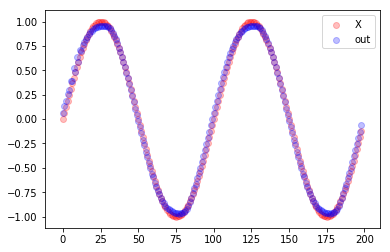

In [31]:
plt.scatter(range(period_samples * periods_count - 1), X.numpy(), color='red', alpha=0.25, label="X")
plt.scatter(range(period_samples * periods_count - 1), out.cpu().detach().numpy(), color='blue', alpha=0.25, label="out")
plt.legend()
plt.show()

In [43]:
%%time

model = nn.LSTM(input_size=1, hidden_size=2)
params = list(model.parameters())
print(f"params:\n{params}\n")
print(f"hidden:\n{hidden}\n")


params:
[Parameter containing:
tensor([[-0.6606],
        [ 0.0993],
        [-0.0443],
        [-0.5788],
        [ 0.1719],
        [ 0.7017],
        [ 0.0111],
        [ 0.6394]], requires_grad=True), Parameter containing:
tensor([[ 0.4322,  0.1896],
        [-0.5293, -0.6725],
        [ 0.2593, -0.0094],
        [-0.3427, -0.3678],
        [ 0.6769, -0.1215],
        [-0.1725,  0.2269],
        [-0.0938,  0.6003],
        [ 0.2272,  0.6674]], requires_grad=True), Parameter containing:
tensor([ 0.5954, -0.0631, -0.6848,  0.5727, -0.2761, -0.3907,  0.6158,  0.2548],
       requires_grad=True), Parameter containing:
tensor([-0.0970,  0.4097,  0.3026, -0.4989,  0.5907, -0.5847, -0.4578,  0.0084],
       requires_grad=True)]

hidden:
(tensor([[[-0.0650]]], device='cuda:0', grad_fn=<CudnnRnnBackward>), tensor([[[-0.0653]]], device='cuda:0', grad_fn=<CudnnRnnBackward>))

CPU times: user 6.36 ms, sys: 586 µs, total: 6.95 ms
Wall time: 5.5 ms


In [ ]:
# ------------------------------------------------------------------------------------------
# Generating a noisy multi-sin wave

def sine_2(X, signal_freq=60.):
    return (np.sin(2 * np.pi * (X) / signal_freq) + np.sin(4 * np.pi * (X) / signal_freq)) / 2.0


def noisy(Y, noise_range=(-0.05, 0.05)):
    noise = np.random.uniform(noise_range[0], noise_range[1], size=Y.shape)
    return Y + noise


def sample(sample_size):
    random_offset = random.randint(0, sample_size)
    X = np.arange(sample_size)
    Y = noisy(sine_2(X + random_offset))
    return Y